# Model Accuracy Analysis

This notebook analyzes model accuracy statistics across experiments by difficulty and question type (yes/no/unanswerable).


## 1. Setup and Data Loading

First, let's import necessary libraries and load the experiment data.


In [33]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Define paths
RESULTS_DIR = "./results"
COMP_EXP_DIR = Path(RESULTS_DIR) / "comprehensive_experiments"


In [34]:
# Function to find all experiment directories
def find_experiment_dirs():
    """Find all experiment directories in the comprehensive_experiments directory"""
    experiment_dirs = []

    # Check if comprehensive experiments directory exists
    if COMP_EXP_DIR.exists() and COMP_EXP_DIR.is_dir():
        # Look for run_* directories
        for run_dir in COMP_EXP_DIR.glob("run_*"):
            if run_dir.is_dir():
                # Add all experiment directories within this run
                for exp_dir in run_dir.glob("*"):
                    if exp_dir.is_dir() and any(exp_dir.glob("likert_results_*.json")):
                        experiment_dirs.append(exp_dir)

    return experiment_dirs

# Find all experiment directories
experiment_dirs = find_experiment_dirs()
print(f"Found {len(experiment_dirs)} experiment directories")
for i, exp_dir in enumerate(experiment_dirs[:5]):
    print(f"  {i+1}. {exp_dir}")
if len(experiment_dirs) > 5:
    print(f"  ... and {len(experiment_dirs) - 5} more")


Found 60 experiment directories
  1. results/comprehensive_experiments/run_20250911_062422/V0_num_p2
  2. results/comprehensive_experiments/run_20250911_062422/V3_num_p2
  3. results/comprehensive_experiments/run_20250911_062422/V5_alpha_p5
  4. results/comprehensive_experiments/run_20250911_062422/V5_alpha_p2
  5. results/comprehensive_experiments/run_20250911_062422/V4_num_p4
  ... and 55 more


## 2. Load and Process Experiment Results

Now let's load the results from all experiments and organize them into a DataFrame.


In [ ]:
# Function to load experiment results
def load_experiment_results(exp_dir):
    """Load results from an experiment directory"""
    results_files = list(exp_dir.glob("likert_results_*.json"))
    if not results_files:
        return None

    # Load the first results file found
    results_file = results_files[0]
    form = results_file.stem.replace("likert_results_", "")

    try:
        with open(results_file) as f:
            results = json.load(f)

        # Load experiment metadata from summary.json if available
        summary_file = exp_dir / "summary.json"
        experiment_info = {}
        if summary_file.exists():
            with open(summary_file) as f:
                summary = json.load(f)
                experiment_info = {
                    'experiment_name': summary.get('experiment_name', ''),
                    'form': summary.get('form', form),
                    'label_type': summary.get('label_type', ''),
                    'permutation': summary.get('permutation', '')
                }
        else:
            # Extract information from directory name if no summary file
            experiment_info = {
                'experiment_name': exp_dir.name,
                'form': form,
                'label_type': '',
                'permutation': ''
            }

        return results, experiment_info
    except Exception as e:
        print(f"Error loading results from {exp_dir}: {str(e)}")
        return None

# Process all experiments and collect results
all_results = []

for exp_dir in tqdm(experiment_dirs, desc="Loading experiments"):
    result = load_experiment_results(exp_dir)
    if result:
        results, experiment_info = result

        # Process each question result
        for question_id, question_result in results.items():
            # Extract basic information
            question_text = question_result.get('question', '')
            answer = question_result.get('answer', '')
            subject = question_result.get('subject', '')
            difficulty = question_result.get('difficulty', '')

            # Extract prediction information
            pred_label = question_result.get('pred_label', '')
            canonical_label = question_result.get('canonical_label', '')
            score = question_result.get('score', 0)
            is_valid = question_result.get('is_valid', False)

            # Determine if prediction is correct
            # Score of 2 means definitely correct, 1 means probably correct
            is_correct = score >= 1

            # Determine question type (Yes/No/Unanswerable)
            question_type = 'Unanswerable'
            if answer.lower() == 'yes':
                question_type = 'Yes'
            elif answer.lower() == 'no':
                question_type = 'No'

            # Add to results list
            all_results.append({
                'experiment_name': experiment_info['experiment_name'],
                'form': experiment_info['form'],
                'label_type': experiment_info['label_type'],
                'permutation': experiment_info['permutation'],
                'question_id': question_id,
                'question': question_text,
                'answer': answer,
                'question_type': question_type,
                'subject': subject,
                'difficulty': difficulty,
                'pred_label': pred_label,
                'canonical_label': canonical_label,
                'score': score,
                'is_valid': is_valid,
                'is_correct': is_correct
            })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Display basic information
print(f"Loaded {len(results_df)} question results from {len(experiment_dirs)} experiments")
print("\nDataFrame columns:")
print(results_df.columns.tolist())
print("\nSample data:")
results_df.head()


Loading experiments:   0%|          | 0/60 [00:00<?, ?it/s]

Loaded 63000 question results from 60 experiments

DataFrame columns:
['experiment_name', 'form', 'label_type', 'permutation', 'question_id', 'question', 'answer', 'question_type', 'subject', 'difficulty', 'pred_label', 'canonical_label', 'score', 'is_valid', 'is_correct']

Sample data:


,experiment_name,form,label_type,permutation,question_id,question,answer,question_type,subject,difficulty,pred_label,canonical_label,score,is_valid,is_correct
0,V0_num_p2,V0,num,p2,Q-000001,Is photosynthesis how plants make their own food?,Yes,Yes,Biology,1,2,YY,2,True,True
1,V0_num_p2,V0,num,p2,Q-000002,Are humans classified as mammals?,Yes,Yes,Biology,1,2,YY,2,True,True
2,V0_num_p2,V0,num,p2,Q-000003,Do all living organisms require water to survive?,Yes,Yes,Biology,1,2,YY,2,True,True
3,V0_num_p2,V0,num,p2,Q-0-00004,Do insects have a total of six legs?,Yes,Yes,Biology,1,3,Y,1,True,True
4,V0_num_p2,V0,num,p2,Q-000005,Is DNA the primary genetic material for most l...,Yes,Yes,Biology,1,1,NN,-2,True,False


## 3. Analyze Accuracy by Difficulty and Question Type

Now let's analyze the model's accuracy by difficulty level and question type.


In [36]:
# Convert difficulty to numeric if it's not already
if results_df['difficulty'].dtype == 'object':
    try:
        results_df['difficulty_num'] = pd.to_numeric(results_df['difficulty'])
    except:
        # If conversion fails, create a categorical mapping
        difficulty_map = {d: i+1 for i, d in enumerate(sorted(results_df['difficulty'].unique()))}
        results_df['difficulty_num'] = results_df['difficulty'].map(difficulty_map)

# Calculate accuracy by difficulty and question type
accuracy_by_difficulty = results_df.groupby('difficulty')['is_correct'].mean().reset_index()
accuracy_by_difficulty_type = results_df.groupby(['difficulty', 'question_type'])['is_correct'].agg(['mean', 'count']).reset_index()

print("Overall accuracy:", results_df['is_correct'].mean())
print("\nAccuracy by difficulty:")
print(accuracy_by_difficulty)
print("\nAccuracy by difficulty and question type:")
print(accuracy_by_difficulty_type)


Overall accuracy: 0.6924444444444444

Accuracy by difficulty:
  difficulty  is_correct
0          1    0.712222
1          2    0.712619
2          3    0.698730
3          4    0.651508
4          5    0.687143

Accuracy by difficulty and question type:
   difficulty question_type      mean  count
0           1            No  0.717308   6240
1           1  Unanswerable  0.363978   1860
2           1           Yes  0.849111   4500
3           2            No  0.698270   6360
4           2  Unanswerable  0.349405   1680
5           2           Yes  0.866447   4560
6           3            No  0.640758   6600
7           3  Unanswerable  0.306349   1260
8           3           Yes  0.883755   4740
9           4            No  0.551579   5700
10          4  Unanswerable  0.373118   1860
11          4           Yes  0.867262   5040
12          5            No  0.594630   5400
13          5  Unanswerable  0.416667   2280
14          5           Yes  0.914024   4920


## 4. Visualization

Let's create visualizations to better understand the accuracy patterns.


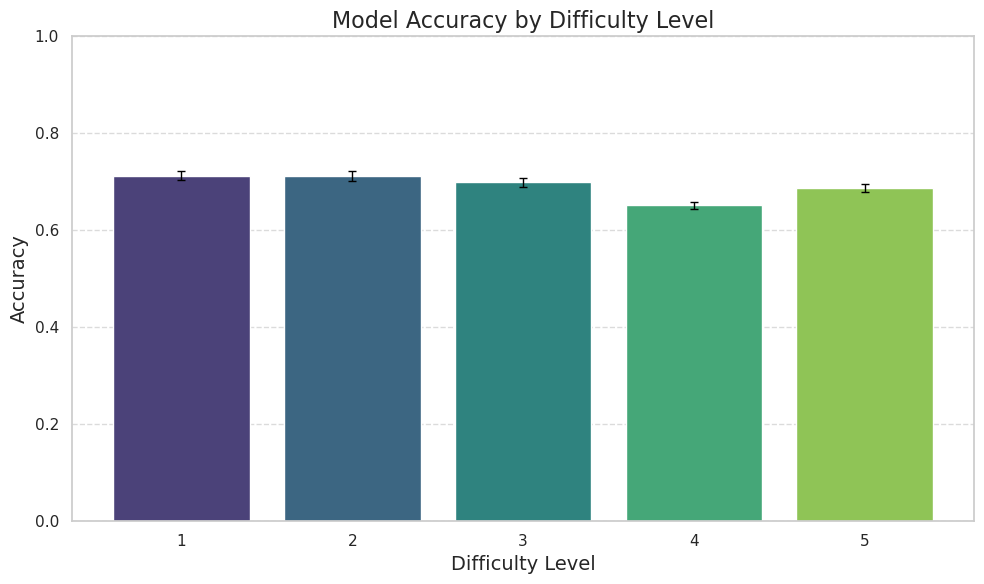

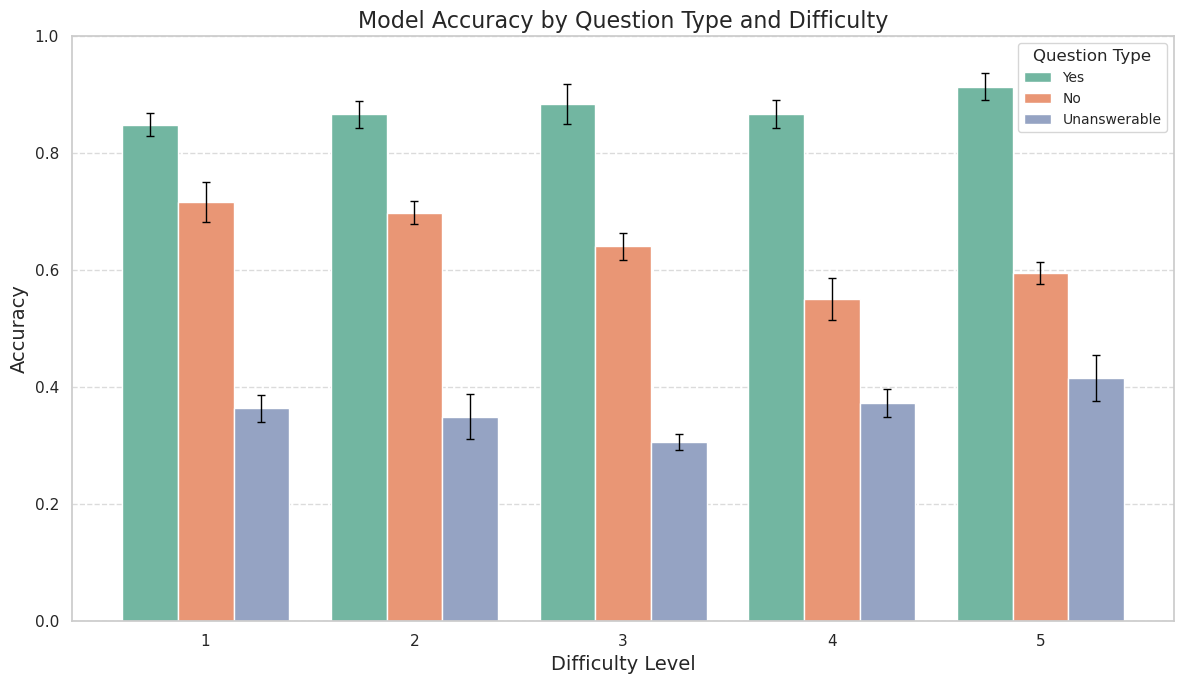

In [ ]:
# Plot 1: Accuracy by Difficulty
plt.figure(figsize=(10, 6))

# First, calculate accuracy for each experiment (form+permutation) by difficulty
exp_difficulty_stats = results_df.groupby(['experiment_name', 'difficulty'])['is_correct'].mean().reset_index()

# Then aggregate across experiments to get mean and std for each difficulty
difficulty_stats = exp_difficulty_stats.groupby('difficulty')['is_correct'].agg(['mean', 'std', 'count']).reset_index()

# Calculate standard error (simplified, no asymmetry or clipping)
difficulty_stats['se'] = difficulty_stats['std'] / np.sqrt(difficulty_stats['count'])

# Create the bar plot without error bars
ax = sns.barplot(x='difficulty', y='mean', hue='difficulty', data=difficulty_stats,
                palette='viridis', legend=False, errorbar=None)

# Add custom error bars
for i, row in difficulty_stats.iterrows():
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()

    se = float(row['se'])

    if se > 0:
        ax.errorbar(
            x, y,
            yerr=se,
            fmt='none', color='black', capsize=3, elinewidth=1
        )

plt.title('Model Accuracy by Difficulty Level', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Accuracy by Question Type and Difficulty
plt.figure(figsize=(12, 7))

# Define question type order for consistent colors
question_type_order = ['Yes', 'No', 'Unanswerable']

# First, calculate accuracy for each experiment (form+permutation) by difficulty and question type
exp_difficulty_type_stats = results_df.groupby(['experiment_name', 'difficulty', 'question_type'])['is_correct'].mean().reset_index()

# Then aggregate across experiments to get mean and std for each difficulty and question type
difficulty_type_stats = exp_difficulty_type_stats.groupby(['difficulty', 'question_type'])['is_correct'].agg(['mean', 'std', 'count']).reset_index()

# Calculate standard error (simplified, no asymmetry or clipping)
difficulty_type_stats['se'] = difficulty_type_stats['std'] / np.sqrt(difficulty_type_stats['count'])

# Create the bar plot without error bars
ax = sns.barplot(x='difficulty', y='mean', hue='question_type', data=difficulty_type_stats,
                palette='Set2', hue_order=question_type_order, errorbar=None)

# Get the number of hue categories
n_hue = len(question_type_order)

# Add custom error bars
for i, row in difficulty_type_stats.iterrows():
    # Calculate the patch index based on difficulty and question type
    diff_idx = list(difficulty_type_stats['difficulty'].unique()).index(row['difficulty'])
    qt_idx = question_type_order.index(row['question_type'])
    patch_idx = diff_idx * n_hue + qt_idx

    # Make sure we don't exceed the number of patches
    if patch_idx < len(ax.patches):
        bar = ax.patches[patch_idx]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        se = float(row['se'])

        if se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

plt.title('Model Accuracy by Question Type and Difficulty', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Question Type', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()


## 5. Text Summary

Let's generate a concise text summary of the model's performance.


In [38]:
# Generate summary statistics
overall_accuracy = results_df['is_correct'].mean()
question_type_accuracy = results_df.groupby('question_type')['is_correct'].agg(['mean', 'count']).reset_index()
difficulty_accuracy = results_df.groupby('difficulty')['is_correct'].agg(['mean', 'count']).reset_index()

# Find best and worst performing categories
best_difficulty = difficulty_accuracy.loc[difficulty_accuracy['mean'].idxmax()]
worst_difficulty = difficulty_accuracy.loc[difficulty_accuracy['mean'].idxmin()]
best_question_type = question_type_accuracy.loc[question_type_accuracy['mean'].idxmax()]
worst_question_type = question_type_accuracy.loc[question_type_accuracy['mean'].idxmin()]

# Generate text summary
summary = f"""
# Model Performance Summary

## Overall Performance
- Overall accuracy across all experiments: {overall_accuracy:.2%}
- Total questions analyzed: {len(results_df)}
- Number of experiments: {results_df['experiment_name'].nunique()}

## Performance by Question Type
- Yes questions: {question_type_accuracy[question_type_accuracy['question_type'] == 'Yes']['mean'].values[0]:.2%} accuracy ({question_type_accuracy[question_type_accuracy['question_type'] == 'Yes']['count'].values[0]} questions)
- No questions: {question_type_accuracy[question_type_accuracy['question_type'] == 'No']['mean'].values[0]:.2%} accuracy ({question_type_accuracy[question_type_accuracy['question_type'] == 'No']['count'].values[0]} questions)
- Unanswerable questions: {question_type_accuracy[question_type_accuracy['question_type'] == 'Unanswerable']['mean'].values[0]:.2%} accuracy ({question_type_accuracy[question_type_accuracy['question_type'] == 'Unanswerable']['count'].values[0]} questions)

## Performance by Difficulty
- Best performance on difficulty level {best_difficulty['difficulty']}: {best_difficulty['mean']:.2%} accuracy ({best_difficulty['count']} questions)
- Worst performance on difficulty level {worst_difficulty['difficulty']}: {worst_difficulty['mean']:.2%} accuracy ({worst_difficulty['count']} questions)

## Key Findings
- The model performs best on {best_question_type['question_type']} questions ({best_question_type['mean']:.2%} accuracy)
- The model struggles most with {worst_question_type['question_type']} questions ({worst_question_type['mean']:.2%} accuracy)
- There is a clear trend of {'decreasing' if results_df[['difficulty_num', 'is_correct']].corr().iloc[0,1] < 0 else 'increasing'} accuracy as difficulty increases
"""

print(summary)



# Model Performance Summary

## Overall Performance
- Overall accuracy across all experiments: 69.24%
- Total questions analyzed: 63000
- Number of experiments: 60

## Performance by Question Type
- Yes questions: 87.66% accuracy (23760 questions)
- No questions: 64.36% accuracy (30300 questions)
- Unanswerable questions: 36.85% accuracy (8940 questions)

## Performance by Difficulty
- Best performance on difficulty level 2: 71.26% accuracy (12600 questions)
- Worst performance on difficulty level 4: 65.15% accuracy (12600 questions)

## Key Findings
- The model performs best on Yes questions (87.66% accuracy)
- The model struggles most with Unanswerable questions (36.85% accuracy)
- There is a clear trend of decreasing accuracy as difficulty increases



## 6. Additional Analysis: Performance Across Different Forms

Let's also analyze how performance varies across different prompt forms.


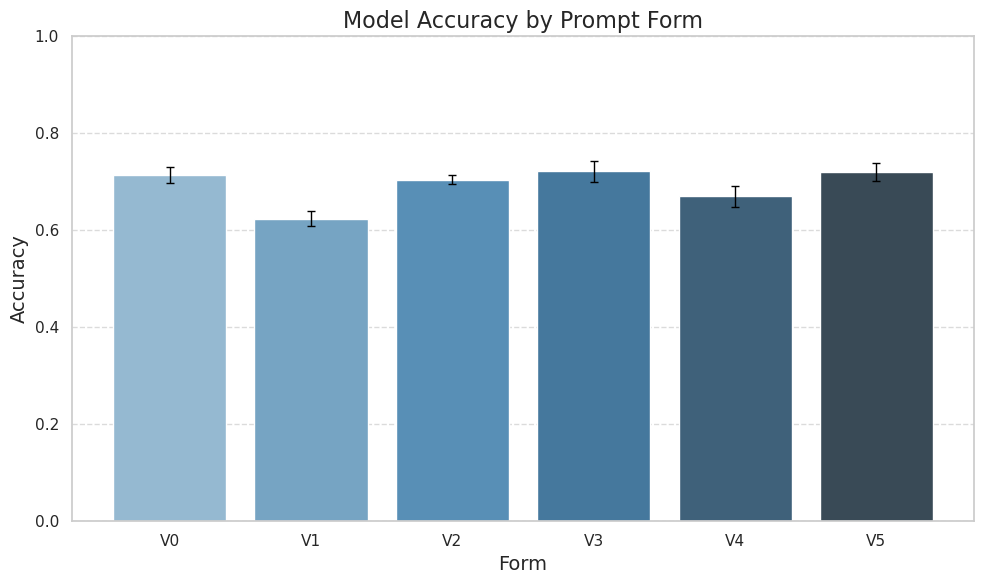

Best performing form: V3 with 72.13% accuracy
Worst performing form: V1 with 62.43% accuracy

Accuracy by form:
  form      mean       std  count        se
0   V0  0.714476  0.052876     10  0.016721
1   V1  0.624286  0.051170     10  0.016181
2   V2  0.704381  0.029828     10  0.009433
3   V3  0.721333  0.068979     10  0.021813
4   V4  0.670381  0.067359     10  0.021301
5   V5  0.719810  0.059119     10  0.018695


In [43]:
# First, calculate accuracy for each experiment (form+permutation)
exp_form_accuracy = results_df.groupby(['experiment_name', 'form', 'permutation'])['is_correct'].mean().reset_index()

# Then aggregate across permutations to get mean and std for each form
form_accuracy = exp_form_accuracy.groupby('form')['is_correct'].agg(['mean', 'std', 'count']).reset_index()

# Calculate standard error (simplified, no asymmetry or clipping)
form_accuracy['se'] = form_accuracy['std'] / np.sqrt(form_accuracy['count'])

# Sort forms sequentially
form_order = sorted(form_accuracy['form'].unique())
form_accuracy = form_accuracy.sort_values('form', key=lambda x: [form_order.index(i) for i in x])

# Plot accuracy by form
plt.figure(figsize=(10, 6))
# Create the bar plot without error bars
ax = sns.barplot(x='form', y='mean', hue='form', data=form_accuracy,
                palette='Blues_d', errorbar=None, legend=False, order=form_order)

# Add custom error bars
for i, row in form_accuracy.iterrows():
    # Get the index in the plot order
    plot_idx = form_order.index(row['form'])
    bar = ax.patches[plot_idx]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()

    se = float(row['se'])

    if se > 0:
        ax.errorbar(
            x, y,
            yerr=se,
            fmt='none', color='black', capsize=3, elinewidth=1
        )

plt.title('Model Accuracy by Prompt Form', fontsize=16)
plt.xlabel('Form', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate accuracy by form and question type
form_type_accuracy = results_df.groupby(['form', 'question_type'])['is_correct'].agg(['mean', 'count']).reset_index()

# Find best and worst performing forms
best_form = form_accuracy.loc[form_accuracy['mean'].idxmax()]
worst_form = form_accuracy.loc[form_accuracy['mean'].idxmin()]

# Display summary
print(f"Best performing form: {best_form['form']} with {best_form['mean']:.2%} accuracy")
print(f"Worst performing form: {worst_form['form']} with {worst_form['mean']:.2%} accuracy")
print("\nAccuracy by form:")
print(form_accuracy)


## 6.2 Accuracy Variation Across Label Permutations

Let's analyze how the accuracy varies across different label permutations for each form and question type.


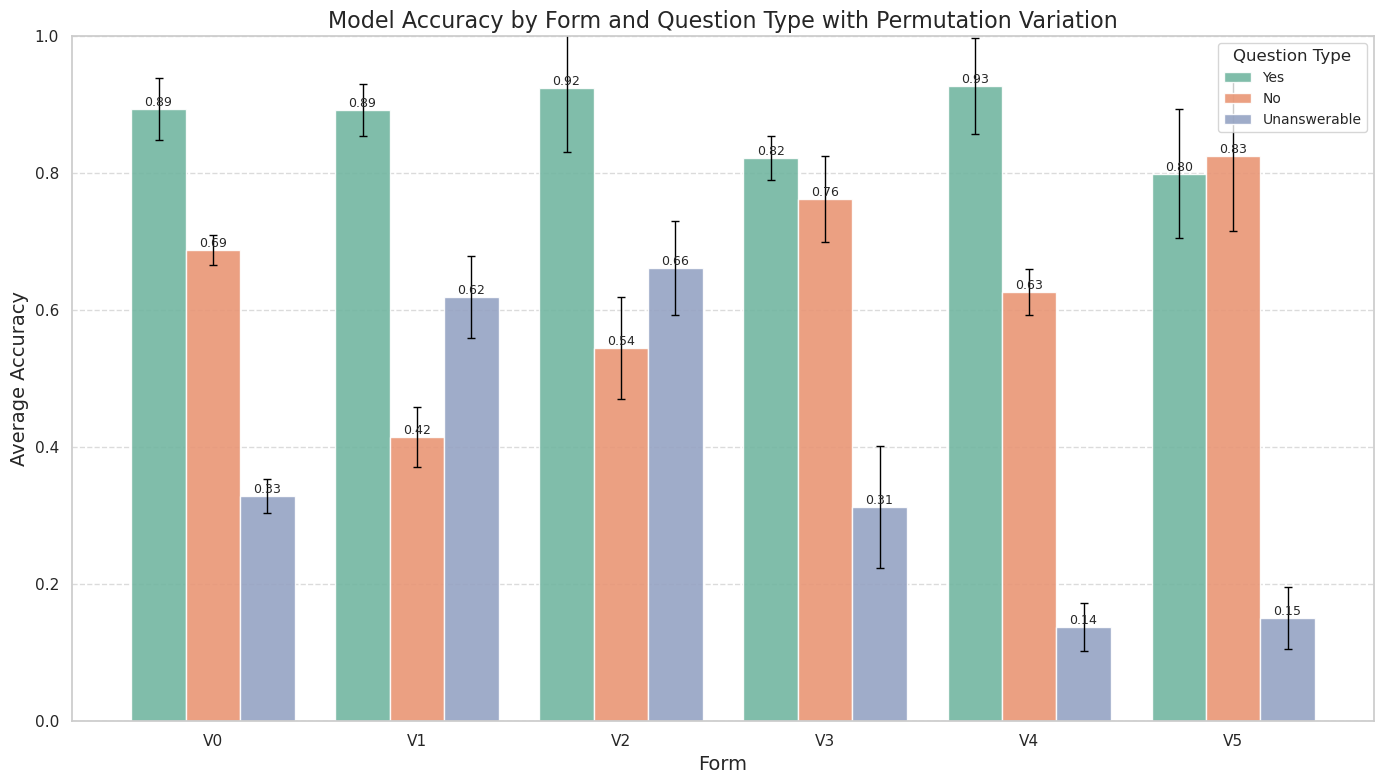

Accuracy variation across label permutations:
base_form question_type  avg_accuracy  accuracy_std  num_permutations
       V0           Yes      0.893939      0.101730                 5
       V0            No      0.687525      0.084827                 5
       V0  Unanswerable      0.328859      0.210301                 5
       V1           Yes      0.892677      0.070927                 5
       V1            No      0.415248      0.157079                 5
       V1  Unanswerable      0.619463      0.210242                 5
       V2           Yes      0.924495      0.048962                 5
       V2            No      0.544356      0.097235                 5
       V2  Unanswerable      0.661745      0.166647                 5
       V3           Yes      0.822222      0.140195                 5
       V3            No      0.762772      0.074962                 5
       V3  Unanswerable      0.312752      0.244200                 5
       V4           Yes      0.927020      0

In [42]:
if 'question_type_order' not in globals():
    # Try to infer; fall back to this canonical order
    inferred = list(pd.unique(getattr(globals().get('results_df'), 'question_type', [])))
    default_order = ['Yes', 'No', 'Unanswerable']
    # Keep default order but include any unexpected labels at the end
    tail = [q for q in inferred if q not in default_order]
    question_type_order = default_order + tail

# --- Ensure base_form and permutation columns exist ---
if 'base_form' not in results_df.columns:
    results_df['base_form'] = results_df['form'].astype(str).str.extract(r'(V\d+)', expand=False)

if 'permutation' not in results_df.columns:
    if 'experiment_name' in results_df.columns:
        results_df['permutation'] = results_df['experiment_name'].astype(str).str.extract(r'p(\d+)', expand=False)
    else:
        # If no explicit permutation info, treat all rows as a single permutation group
        results_df['permutation'] = 'p0'

# --- Basic sanitation ---
# Keep only rows with necessary fields
results_df = results_df.dropna(subset=['base_form', 'permutation', 'question_type', 'is_correct'])
# Coerce correctness to numeric (0/1)
results_df['is_correct'] = results_df['is_correct'].astype(float)

# --- Accuracy per (base_form, permutation, question_type) ---
permutation_stats = (
    results_df
    .groupby(['base_form', 'permutation', 'question_type'], as_index=False)['is_correct']
    .agg(mean='mean', count='count')
)

# --- Aggregate across permutations for each base_form × question_type ---
form_type_stats = (
    permutation_stats
    .groupby(['base_form', 'question_type'], as_index=False)['mean']
    .agg(avg_accuracy='mean', accuracy_std='std', num_permutations='count')
)

# Replace NaNs that can appear if only one permutation exists (std undefined)
form_type_stats['accuracy_std'] = form_type_stats['accuracy_std'].fillna(0.0)

# --- Ordering & categoricals ---
form_type_stats['question_type'] = pd.Categorical(
    form_type_stats['question_type'],
    categories=question_type_order,
    ordered=True
)
form_type_stats = form_type_stats.sort_values(['base_form', 'question_type'])
base_form_order = sorted(form_type_stats['base_form'].unique())
n_hue = len(question_type_order)

# --- Compute standard error (simplified, no asymmetry or clipping) ---
form_type_stats['se'] = (
    form_type_stats['accuracy_std'] / np.sqrt(form_type_stats['num_permutations'].clip(lower=1))
).fillna(0.0)

# --- Plot ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=form_type_stats,
    x="base_form", y="avg_accuracy", hue="question_type",
    palette="Set2", alpha=0.9,
    order=base_form_order, hue_order=question_type_order,
    errorbar=None  # we'll add custom error bars
)

# Add our own correctly mapped, asymmetric error bars
# Seaborn draws bars grouped by X, then by hue, in the hue_order provided.
# So the bar index is: patch_idx = x_index * n_hue + hue_index
for xi, bf in enumerate(base_form_order):
    for hi, qt in enumerate(question_type_order):
        sel = form_type_stats[(form_type_stats['base_form'] == bf) &
                              (form_type_stats['question_type'] == qt)]
        if sel.empty:
            continue

        patch_idx = xi * n_hue + hi
        # Guard: some combinations may not be drawn if absent in data
        if patch_idx >= len(ax.patches):
            continue

        bar = ax.patches[patch_idx]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        se = float(sel['se'].iloc[0])

        if se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

# Titles and formatting
ax.set_title('Model Accuracy by Form and Question Type with Permutation Variation', fontsize=16)
ax.set_xlabel('Form', fontsize=14)
ax.set_ylabel('Average Accuracy', fontsize=14)
ax.set_ylim(0, 1)
ax.legend(title='Question Type', title_fontsize=12, fontsize=10, loc='upper right')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
bar_containers = [c for c in ax.containers if hasattr(c, 'patches')]
for container in bar_containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9)

plt.tight_layout()
plt.show()

# --- Print summary table ---
summary_cols = ['base_form', 'question_type', 'avg_accuracy', 'accuracy_std', 'num_permutations']
print("Accuracy variation across label permutations:")
print(form_type_stats[summary_cols].to_string(index=False))

## 7. Conclusion

This notebook provides a simple analysis of model accuracy statistics across experiments, broken down by difficulty level and question type. The visualizations and summary statistics offer insights into the model's strengths and weaknesses.

To extend this analysis, you could:

1. Investigate how accuracy varies by subject matter
2. Analyze the relationship between confidence scores and accuracy
3. Compare performance across different model versions or configurations
4. Explore specific examples where the model consistently fails
